This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [1]:
# Importing required libraries for data manipulation and analysis
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data manipulation and analysis

# Setting display options for pandas to allow for better visibility of large datasets
pd.set_option('display.max_rows', 500)  # Display up to 500 rows in output
pd.set_option('display.max_columns', 100)  # Display up to 100 columns in output

# Importing utilities for combinations and encoding
from itertools import product  # For generating Cartesian product of input iterables
from sklearn.preprocessing import LabelEncoder  # For encoding categorical data into numeric form

# Importing visualization libraries
import seaborn as sns  # For creating attractive and informative statistical graphics
import matplotlib.pyplot as plt  # For plotting charts and figures
%matplotlib inline 
# Ensures plots are displayed inline within Jupyter Notebook

# Importing XGBoost libraries for machine learning tasks
from xgboost import XGBRegressor  # XGBoost's regression model
from xgboost import plot_importance  # Function to plot feature importance of the model

# Function to plot feature importance for an XGBoost model
def plot_features(booster, figsize):    
    """
    Plots the feature importance of an XGBoost model.
    
    Parameters:
        booster: The trained XGBoost model
        figsize: Tuple specifying the size of the figure (width, height)
    
    Returns:
        matplotlib plot: A bar plot displaying the importance of features
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)  # Create a figure and a single axis
    return plot_importance(booster=booster, ax=ax)  # Plot feature importance on the axis

# Importing additional libraries for various tasks
import time  # For measuring execution time or working with time-related functions
import sys  # Provides access to system-specific parameters and functions
import gc  # Garbage collection interface for managing memory
import pickle  # For serializing and saving Python objects

# Displaying the Python version info
sys.version_info 
# Provides details of the Python interpreter's version

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [2]:
# Reading the 'items' dataset which contains information about items
items = pd.read_csv('../input/items.csv')

# Reading the 'shops' dataset which contains information about shops
shops = pd.read_csv('../input/shops.csv')

# Reading the 'item_categories' dataset which contains information about item categories
cats = pd.read_csv('../input/item_categories.csv')

# Reading the 'sales_train' dataset which contains historical sales data
train = pd.read_csv('../input/sales_train.csv')

# Reading the 'test' dataset, which is used for prediction, and setting 'ID' as the index to preserve it for later
test = pd.read_csv('../input/test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

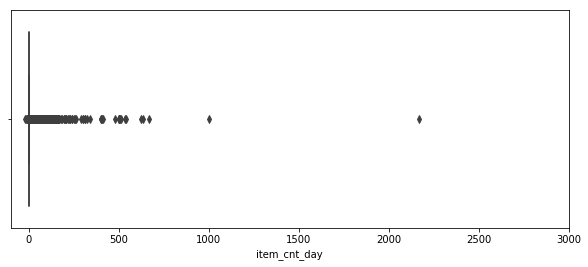

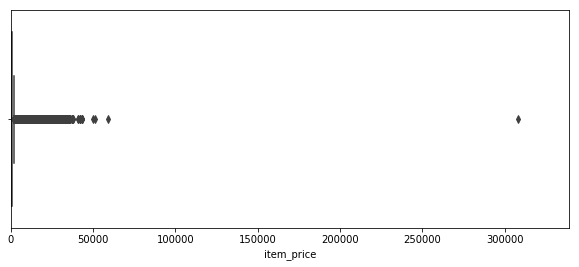

In [3]:
# Creating a figure to visualize the distribution of daily item counts
plt.figure(figsize=(10, 4))  # Setting the figure size to 10x4 inches
plt.xlim(-100, 3000)  # Limiting the x-axis range to focus on relevant values
sns.boxplot(x=train.item_cnt_day)  # Creating a box plot for daily item counts from the 'train' dataset

# Creating a figure to visualize the distribution of item prices
plt.figure(figsize=(10, 4))  # Setting the figure size to 10x4 inches
plt.xlim(train.item_price.min(), train.item_price.max() * 1.1)  # Adjusting the x-axis to include a slight margin
sns.boxplot(x=train.item_price)  # Creating a box plot for item prices from the 'train' dataset

In [4]:
# Filtering the 'train' dataset to remove rows with item prices greater than or equal to 100,000
train = train[train.item_price < 100000]

# Filtering the 'train' dataset to remove rows with daily item counts greater than or equal to 1,001
train = train[train.item_cnt_day < 1001]

There is one item with price below zero. Fill it with median.

In [5]:
# Calculating the median item price for a specific shop (shop_id=32), item (item_id=2973),
# and month (date_block_num=4), where the item price is greater than 0
median = train[
    (train.shop_id == 32) & 
    (train.item_id == 2973) & 
    (train.date_block_num == 4) & 
    (train.item_price > 0)
].item_price.median()

# Replacing negative item prices in the 'train' dataset with the calculated median price
train.loc[train.item_price < 0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [6]:
# Updating shop IDs in 'train' and 'test' datasets for consistency:
# Yakutsk Ordzhonikidze, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57  # Replace shop_id 0 with 57 in the 'train' dataset
test.loc[test.shop_id == 0, 'shop_id'] = 57    # Replace shop_id 0 with 57 in the 'test' dataset

# Yakutsk Central Shopping Center (ТЦ "Центральный")
train.loc[train.shop_id == 1, 'shop_id'] = 58  # Replace shop_id 1 with 58 in the 'train' dataset
test.loc[test.shop_id == 1, 'shop_id'] = 58    # Replace shop_id 1 with 58 in the 'test' dataset

# Zhukovsky Chkalova Street, 39m²
train.loc[train.shop_id == 10, 'shop_id'] = 11  # Replace shop_id 10 with 11 in the 'train' dataset
test.loc[test.shop_id == 10, 'shop_id'] = 11    # Replace shop_id 10 with 11 in the 'test' dataset

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
# Standardizing shop names for consistency
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'  # Remove space in shop name

# Extracting the city name from the shop name
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])  # Split shop name and take the first part as city name

# Correcting city name for Yakutsk (!Якутск to Якутск)
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

# Encoding city names into numeric city codes
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])  # Transform city names to numeric codes

# Keeping only relevant columns in the shops dataset
shops = shops[['shop_id', 'city_code']]  # Retain shop_id and city_code columns

# Splitting item categories into type and subtype
cats['split'] = cats['item_category_name'].str.split('-')  # Split category name on '-'
cats['type'] = cats['split'].map(lambda x: x[0].strip())  # Extract the first part (type) and strip whitespace

# Encoding category types into numeric type codes
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])  # Transform type names to numeric codes

# Extracting subtypes; if no subtype exists, use the type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())  # Extract subtype or fallback to type

# Encoding subtypes into numeric subtype codes
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])  # Transform subtype names to numeric codes

# Keeping only relevant columns in the categories dataset
cats = cats[['item_category_id', 'type_code', 'subtype_code']]  # Retain category_id, type_code, and subtype_code

# Dropping the 'item_name' column from the items dataset as it's not required
items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [8]:
# len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

# Calculating the number of items in the test dataset that are not present in the train dataset
missing_items = len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))

# Calculating the total number of unique items in the test dataset
unique_test_items = len(list(set(test.item_id)))

# Calculating the total number of rows in the test dataset
total_test_rows = len(test)

# Displaying the results
missing_items, unique_test_items, total_test_rows

(363, 5100, 214200)

In [9]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Initializing an empty list to store the resulting matrix
matrix = []

# Defining the column names for the matrix
cols = ['date_block_num', 'shop_id', 'item_id']

# Iterating through each month (date_block_num) from 0 to 33 (34 months in total)
for i in range(34):
    # Filtering the 'train' dataset for the current date_block_num
    sales = train[train.date_block_num == i]
    
    # Generating all possible combinations of (date_block_num, shop_id, item_id) for the current month
    matrix.append(np.array(
        list(product([i], sales.shop_id.unique(), sales.item_id.unique())), 
        dtype='int16'
    ))

# Stacking the list of matrices vertically and creating a DataFrame
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# Converting columns to appropriate data types for memory efficiency
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)  # Month index as int8
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)  # Shop ID as int8
matrix['item_id'] = matrix['item_id'].astype(np.int16)  # Item ID as int16

# Sorting the matrix by date_block_num, shop_id, and item_id
matrix.sort_values(cols, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

14.878815174102783

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [10]:
# Adding a new column 'revenue' to the 'train' dataset
# Revenue is calculated as the product of 'item_price' and 'item_cnt_day'
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [11]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping the 'train' dataset by date_block_num, shop_id, and item_id
# Aggregating item_cnt_day by summing to calculate monthly item counts
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

# Renaming the aggregated column to 'item_cnt_month'
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)  # Resetting index to convert grouped columns back into regular columns

# Merging the aggregated data with the 'matrix' dataset
# Using a left join to retain all rows from 'matrix' and add matching rows from 'group'
matrix = pd.merge(matrix, group, on=cols, how='left')

# Filling missing values in 'item_cnt_month' with 0 (for items with no sales in a given month)
# Clipping values to the range [0, 20] to normalize target values for the model
# Converting the column to float16 for memory efficiency
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                            .fillna(0)
                            .clip(0, 20)  # Clip values to the range [0, 20]
                            .astype(np.float16))

# Calculating and displaying the execution time
time.time() - ts

6.9980456829071045

## Test set
To use time tricks append test pairs to the matrix.

In [12]:
# Assigning the date_block_num as 34 for all rows in the 'test' dataset, representing the prediction month
test['date_block_num'] = 34

# Converting the 'date_block_num' column to int8 type for memory efficiency
test['date_block_num'] = test['date_block_num'].astype(np.int8)

# Converting the 'shop_id' column to int8 type for memory efficiency
test['shop_id'] = test['shop_id'].astype(np.int8)

# Converting the 'item_id' column to int16 type for memory efficiency
test['item_id'] = test['item_id'].astype(np.int16)

In [13]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Concatenating the 'matrix' and 'test' datasets
# Adding the test data to the matrix for the 34th month
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)

# Filling any missing values in the matrix with 0 (for consistency across months)
matrix.fillna(0, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

0.11446666717529297

## Shops/Items/Cats features

In [14]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Merging the 'matrix' dataset with the 'shops' dataset on 'shop_id' using a left join
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')

# Merging the 'matrix' dataset with the 'items' dataset on 'item_id' using a left join
matrix = pd.merge(matrix, items, on=['item_id'], how='left')

# Merging the 'matrix' dataset with the 'cats' dataset on 'item_category_id' using a left join
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')

# Optimizing memory usage by converting columns to smaller data types
matrix['city_code'] = matrix['city_code'].astype(np.int8)  # Convert 'city_code' to int8
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)  # Convert 'item_category_id' to int8
matrix['type_code'] = matrix['type_code'].astype(np.int8)  # Convert 'type_code' to int8
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)  # Convert 'subtype_code' to int8

# Calculating and displaying the execution time
time.time() - ts

8.257598161697388

## Traget lags

In [15]:
def lag_feature(df, lags, col):
    """
    Adds lagged features to the DataFrame by shifting a given column for specified lags.

    Parameters:
        df (DataFrame): The input DataFrame containing the data.
        lags (list): A list of integers representing the lag periods to be created.
        col (str): The name of the column to create lagged features for.

    Returns:
        DataFrame: The original DataFrame with additional lagged feature columns.
    """
    # Creating a temporary DataFrame with the required columns
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    # Looping through each lag value
    for i in lags:
        shifted = tmp.copy()  # Create a copy of the temporary DataFrame
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + '_lag_' + str(i)]  # Rename columns for the lag
        shifted['date_block_num'] += i  # Shift the 'date_block_num' column by the lag value
        
        # Merge the shifted data back into the original DataFrame
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    
    return df

In [16]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Applying the lag_feature function to add lagged features for 'item_cnt_month'
# Lag periods are [1, 2, 3, 6, 12]
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')

# Calculating and displaying the execution time
time.time() - ts

45.42160153388977

## Mean encoded features

In [17]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' to calculate the average item count per month
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_avg_item_cnt'
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')

# Converting 'date_avg_item_cnt' to float16 for memory efficiency
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')

# Dropping the original 'date_avg_item_cnt' column after lag creation
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

17.569523334503174

In [18]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' and 'item_id' to calculate the average item count for each item per month
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_item_avg_item_cnt'
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')

# Converting 'date_item_avg_item_cnt' to float16 for memory efficiency
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)

# Creating lagged features for 'date_item_avg_item_cnt' with lags of 1, 2, 3, 6, and 12 months
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'date_item_avg_item_cnt')

# Dropping the original 'date_item_avg_item_cnt' column after lag creation
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

58.48855757713318

In [19]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' and 'shop_id' to calculate the average item count for each shop per month
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_shop_avg_item_cnt'
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')

# Converting 'date_shop_avg_item_cnt' to float16 for memory efficiency
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)

# Creating lagged features for 'date_shop_avg_item_cnt' with lags of 1, 2, 3, 6, and 12 months
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'date_shop_avg_item_cnt')

# Dropping the original 'date_shop_avg_item_cnt' column after lag creation
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

63.80579924583435

In [20]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' and 'item_category_id' to calculate the average item count for each category per month
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_cat_avg_item_cnt'
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')

# Converting 'date_cat_avg_item_cnt' to float16 for memory efficiency
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_cat_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')

# Dropping the original 'date_cat_avg_item_cnt' column after lag creation
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

26.571646213531494

In [21]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num', 'shop_id', and 'item_category_id' to calculate the average item count for each shop-category combination per month
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_shop_cat_avg_item_cnt'
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

# Converting 'date_shop_cat_avg_item_cnt' to float16 for memory efficiency
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_shop_cat_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')

# Dropping the original 'date_shop_cat_avg_item_cnt' column after lag creation
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

28.175482511520386

In [22]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num', 'shop_id', and 'type_code' to calculate the average item count for each shop-type combination per month
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_shop_type_avg_item_cnt'
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')

# Converting 'date_shop_type_avg_item_cnt' to float16 for memory efficiency
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_shop_type_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')

# Dropping the original 'date_shop_type_avg_item_cnt' column after lag creation
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

29.011411905288696

In [23]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num', 'shop_id', and 'subtype_code' to calculate the average item count for each shop-subtype combination per month
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_shop_subtype_avg_item_cnt'
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')

# Converting 'date_shop_subtype_avg_item_cnt' to float16 for memory efficiency
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_shop_subtype_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')

# Dropping the original 'date_shop_subtype_avg_item_cnt' column after lag creation
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

29.656524181365967

In [24]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' and 'city_code' to calculate the average item count for each city per month
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_city_avg_item_cnt'
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')

# Converting 'date_city_avg_item_cnt' to float16 for memory efficiency
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_city_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')

# Dropping the original 'date_city_avg_item_cnt' column after lag creation
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

29.45118474960327

In [25]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num', 'item_id', and 'city_code' to calculate the average item count for each item-city combination per month
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_item_city_avg_item_cnt'
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')

# Converting 'date_item_city_avg_item_cnt' to float16 for memory efficiency
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_item_city_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')

# Dropping the original 'date_item_city_avg_item_cnt' column after lag creation
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

39.40172219276428

In [26]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' and 'type_code' to calculate the average item count for each type per month
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_type_avg_item_cnt'
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')

# Converting 'date_type_avg_item_cnt' to float16 for memory efficiency
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_type_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')

# Dropping the original 'date_type_avg_item_cnt' column after lag creation
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

31.008795499801636

In [27]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Grouping by 'date_block_num' and 'subtype_code' to calculate the average item count for each subtype per month
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})

# Renaming the column to 'date_subtype_avg_item_cnt'
group.columns = ['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)  # Resetting the index for merging

# Merging the calculated averages back into the 'matrix' dataset
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')

# Converting 'date_subtype_avg_item_cnt' to float16 for memory efficiency
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)

# Creating a lagged feature for 'date_subtype_avg_item_cnt' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')

# Dropping the original 'date_subtype_avg_item_cnt' column after lag creation
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

31.69028615951538

## Trend features

Price trend for the last six months.

In [28]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Calculating the average price for each item across all time periods
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

# Merging the average item prices into the matrix
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)  # Optimizing memory usage

# Calculating the average price for each item per month
group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

# Merging the monthly average item prices into the matrix
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)  # Optimizing memory usage

# Adding lagged features for 'date_item_avg_item_price' with specified lags
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# Calculating price deltas (percentage change in price) for each lag
for i in lags:
    matrix['delta_price_lag_' + str(i)] = (
        (matrix['date_item_avg_item_price_lag_' + str(i)] - matrix['item_avg_item_price']) /
        matrix['item_avg_item_price']
    )

# Function to select the first non-null price delta across lags
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_' + str(i)]:
            return row['delta_price_lag_' + str(i)]
    return 0

# Applying the trend selection function across rows
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)  # Optimizing memory usage
matrix['delta_price_lag'].fillna(0, inplace=True)  # Filling missing values with 0

# Dropping unnecessary columns after feature engineering
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_' + str(i)]
    features_to_drop += ['delta_price_lag_' + str(i)]

matrix.drop(features_to_drop, axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

366.85755157470703

Last month shop revenue trend

In [29]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Calculating total revenue for each shop per month
group = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

# Merging monthly shop revenues into the matrix
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)  # Optimizing memory usage

# Calculating the average revenue for each shop across all months
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

# Merging the average shop revenues into the matrix
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)  # Optimizing memory usage

# Calculating the revenue delta (percentage deviation from the shop's average revenue)
matrix['delta_revenue'] = (
    (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
)
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)  # Optimizing memory usage

# Adding a lagged feature for 'delta_revenue' with a lag of 1 month
matrix = lag_feature(matrix, [1], 'delta_revenue')

# Dropping intermediate columns that are no longer needed
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)

# Calculating and displaying the execution time
time.time() - ts

38.765753746032715

## Special features

In [30]:
# Adding a new column 'month' to the matrix
# The value is calculated as the remainder of 'date_block_num' divided by 12,
# representing the month in a yearly cycle (0 = January, 11 = December)
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [31]:
# Creating a Series that represents the number of days in each month (January to December)
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# Mapping the 'month' column in the matrix to the number of days in that month
# Converting the result to int8 for memory efficiency
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [32]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Initializing a cache to store the last sale month for each (item_id, shop_id) combination
cache = {}

# Adding a new column 'item_shop_last_sale' to track the number of months since the last sale for each item in each shop
matrix['item_shop_last_sale'] = -1  # Default value of -1 for items with no previous sales
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)  # Optimizing memory usage

# Iterating through each row in the matrix
for idx, row in matrix.iterrows():
    # Creating a unique key for each (item_id, shop_id) combination
    key = str(row.item_id) + ' ' + str(row.shop_id)
    
    # Checking if the key is in the cache
    if key not in cache:
        # If not in cache and there is a sale, store the current date_block_num in the cache
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        # If the key is in the cache, calculate the months since the last sale
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        # Update the cache with the current date_block_num
        cache[key] = row.date_block_num

# Calculating and displaying the execution time
time.time() - ts

1011.9656839370728

In [33]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Initializing a cache to store the last sale month for each item
cache = {}

# Adding a new column 'item_last_sale' to track the number of months since the last sale for each item
matrix['item_last_sale'] = -1  # Default value of -1 for items with no previous sales
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)  # Optimizing memory usage

# Iterating through each row in the matrix
for idx, row in matrix.iterrows():
    # Using the item_id as the key
    key = row.item_id
    
    # Checking if the key is in the cache
    if key not in cache:
        # If not in cache and there is a sale, store the current date_block_num in the cache
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        # If the key is in the cache, calculate the months since the last sale
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            # Update the cache with the current date_block_num
            cache[key] = row.date_block_num

# Calculating and displaying the execution time
time.time() - ts

587.1859619617462

Months since the first sale for each shop/item pair and for item only.

In [34]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Calculating the number of months since the first sale for each (item_id, shop_id) combination
# This is done by subtracting the earliest 'date_block_num' for each group from the current 'date_block_num'
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

# Calculating the number of months since the first sale for each item
# This is done by subtracting the earliest 'date_block_num' for each item_id from the current 'date_block_num'
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

# Calculating and displaying the execution time
time.time() - ts

3.3567311763763428

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [35]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Filtering the matrix to retain rows where 'date_block_num' is greater than 11
# This effectively removes data from the first 12 months (0 to 11) of the dataset
matrix = matrix[matrix.date_block_num > 11]

# Calculating and displaying the execution time
time.time() - ts

2.2943944931030273

Producing lags brings a lot of nulls.

In [36]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Function to fill NaN values in lagged columns
def fill_na(df):
    """
    Fills NaN values in lagged columns of the DataFrame. Specifically, for lagged columns
    related to 'item_cnt', NaN values are replaced with 0.

    Parameters:
        df (DataFrame): The input DataFrame containing lagged columns.

    Returns:
        DataFrame: The DataFrame with NaN values filled.
    """
    for col in df.columns:
        # Check if the column name contains '_lag_' and has any NaN values
        if ('_lag_' in col) & (df[col].isnull().any()):
            # If the column name contains 'item_cnt', fill NaN values with 0
            if 'item_cnt' in col:
                df[col].fillna(0, inplace=True)
    return df

# Applying the fill_na function to the matrix
matrix = fill_na(matrix)

# Calculating and displaying the execution time
time.time() - ts

8.894295692443848

In [37]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [38]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [39]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [40]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [41]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [42]:
# Splitting the dataset into training, validation, and test sets

# Training set: Data from date_block_num < 33
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)  # Features for training
Y_train = data[data.date_block_num < 33]['item_cnt_month']  # Target variable for training

# Validation set: Data from date_block_num == 33
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)  # Features for validation
Y_valid = data[data.date_block_num == 33]['item_cnt_month']  # Target variable for validation

# Test set: Data from date_block_num == 34
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)  # Features for testing

In [43]:
# Deleting the 'data' DataFrame to free up memory
del data

# Forcing garbage collection to clean up unreferenced objects
gc.collect()

7

In [44]:
# Recording the current timestamp to measure execution time
ts = time.time()

# Initializing the XGBoost Regressor model with specified hyperparameters
model = XGBRegressor(
    max_depth=8,                # Maximum depth of a tree
    n_estimators=1000,          # Number of boosting rounds (trees)
    min_child_weight=300,       # Minimum sum of instance weight (hessian) needed in a child
    colsample_bytree=0.8,       # Fraction of features to be randomly sampled for each tree
    subsample=0.8,              # Fraction of training samples used for each tree
    eta=0.3,                    # Learning rate
    seed=42                     # Random seed for reproducibility
)

# Training the model using the training set
model.fit(
    X_train,                    # Features for training
    Y_train,                    # Target variable for training
    eval_metric="rmse",         # Evaluation metric: Root Mean Square Error
    eval_set=[                  # Evaluation sets: Training and validation sets
        (X_train, Y_train), 
        (X_valid, Y_valid)
    ],
    verbose=True,               # Verbose output during training
    early_stopping_rounds=10    # Stop training if validation metric doesn't improve after 10 rounds
)

# Calculating and displaying the execution time
time.time() - ts

[0]	validation_0-rmse:1.15115	validation_1-rmse:1.11798
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10687	validation_1-rmse:1.08404
[2]	validation_0-rmse:1.06586	validation_1-rmse:1.05307
[3]	validation_0-rmse:1.03083	validation_1-rmse:1.02696
[4]	validation_0-rmse:1.0038	validation_1-rmse:1.00857
[5]	validation_0-rmse:0.978529	validation_1-rmse:0.990388
[6]	validation_0-rmse:0.957395	validation_1-rmse:0.975655
[7]	validation_0-rmse:0.938939	validation_1-rmse:0.96271
[8]	validation_0-rmse:0.923232	validation_1-rmse:0.952649
[9]	validation_0-rmse:0.910424	validation_1-rmse:0.944352
[10]	validation_0-rmse:0.899173	validation_1-rmse:0.937611
[11]	validation_0-rmse:0.889466	validation_1-rmse:0.932494
[12]	validation_0-rmse:0.881379	validation_1-rmse:0.928056
[13]	validation_0-rmse:0.874594	validation_1-rmse:0.924315
[14]	validation_0-rmse:0.868647	valid

2215.5897619724274

In [45]:
# Generating predictions for the validation and test sets
# Clipping the predictions to the range [0, 20] as required
Y_pred = model.predict(X_valid).clip(0, 20)  # Predictions for the validation set
Y_test = model.predict(X_test).clip(0, 20)   # Predictions for the test set

# Creating a submission DataFrame for the test set
submission = pd.DataFrame({
    "ID": test.index,             # Test set IDs
    "item_cnt_month": Y_test      # Predicted item counts
})

# Saving the submission DataFrame to a CSV file
submission.to_csv('xgb_submission.csv', index=False)

# Saving predictions for an ensemble
# Storing validation set predictions
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))

# Storing test set predictions
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

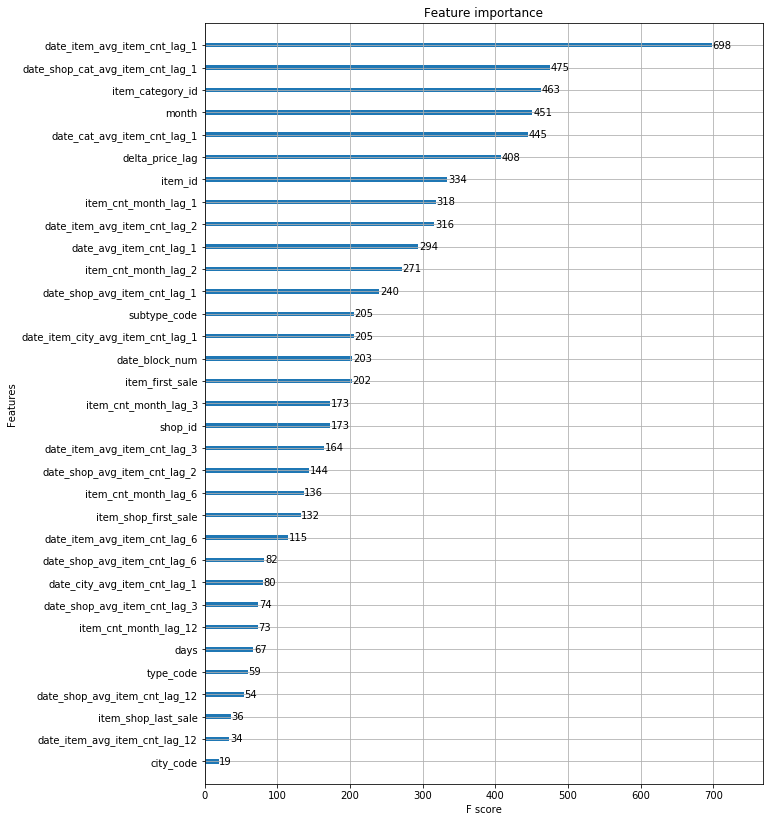

In [46]:
# Plotting feature importance for the trained XGBoost model
# Using the previously defined `plot_features` function
plot_features(model, (10, 14))